# CNNs: classificazione di immagini con una CNN di tipo VGG, e uso di una rete pre-addesrata tramite tecniche di transfer learning

### Informazioni ###

scopo:
- familiarizzare con l'implementazione di CNN in pytorch
- imparare a come sfruttare modelli SOTA CNN preaddestrati su imagnet per task specifiche utilizzando la tecnica del transfer learning

DL tool: pytorch

**Dataset:**

Sign Language Digits Dataset
(Turkey Ankara Ayrancı Anadolu High School Students: [github-link](https://github.com/ardamavi/Sign-Language-Digits-Dataset))

Image size: 100 x 100 pixels

Color space: RGB
Number of classes: 10 (Digits: 0-9)
Number of participant students: 218
Number of samples per student: 10

In [3]:
#@title Download del dataset (esegui la cella)
!rm -rf Dataset.zip
!rm -rf Dataset_test.zip
!rm -rf Dataset
!rm -rf Dataset_test
!wget http://giagu.web.cern.ch/giagu/CERN/Dataset.zip
!wget http://giagu.web.cern.ch/giagu/CERN/Dataset_test.zip
!unzip -q Dataset.zip
!unzip -q Dataset_test.zip
!rm -rf __MACOSX

--2024-05-16 12:06:35--  http://giagu.web.cern.ch/giagu/CERN/Dataset.zip
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.184.21.205, 2001:1458:d00:34::100:59
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.184.21.205|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11254421 (11M) [application/zip]
Saving to: ‘Dataset.zip’

Dataset.zip         100%[===================>]  10.73M   637KB/s    in 27s     

2024-05-16 12:07:02 (414 KB/s) - ‘Dataset.zip’ saved [11254421/11254421]

--2024-05-16 12:07:02--  http://giagu.web.cern.ch/giagu/CERN/Dataset_test.zip
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.184.21.205, 2001:1458:d00:34::100:59
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.184.21.205|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5903386 (5.6M) [application/zip]
Saving to: ‘Dataset_test.zip’

Dataset_test.zip    100%[===================>]   5.63M   618KB/s    in 9.4s    

2024-05-16 12:07:12 (614 K

Nei folder Dataset e Dataset_test sono contenute le immagini in formato jpeg. Le immagini corrispondenti ai differenti numeri (0,1,2,3,4,5,6,7,9) sono inserite in sub-folders nominati in accordo al digit corrispondente ...

In [ ]:
!ls Dataset/
!ls Dataset_test/
!ls Dataset/0/

## Part 0: lettura del dataset, e preparazione dei dataloader pytorch

In [1]:
#import
import os.path
from torchsummary import summary

import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

2.3.0
0.18.0


In [2]:
# controlliamo se la GPU è disponibile e nel caso quale tipo di GPU
if torch.cuda.is_available():
  print('Numero di GPU disponibili: ',torch.cuda.device_count())
  for i in range(0,torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

# se la GPU è disponibile setto device='cuda', altrimenti 'cpu
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Numero di GPU disponibili:  1
NVIDIA GeForce RTX 3060
Computation device: cuda



In [3]:
# lettura dei dati usando torchvision

data_dir = 'Dataset'
test_dir = 'Dataset_test'

# definizione di un torchvision transform costituito da una composizione di trasformazioni utili
# di processamento dei dati e data augmentation

train_transforms = transforms.Compose([#transforms.RandomRotation(10), #applica una rotazione random +/- 10 deg
                                       #transforms.RandomHorizontalFlip(), #applica un flip random dei pixel orizontal
                                       transforms.Resize((100,100)), #assicura che l'immagine sia 100x100
                                       transforms.ToTensor(), #converte in tensori torch
                                      ])

# la data augmentation è applicata solo alle immagini di training
test_transforms = test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                      ])


# trochvision.datasets mette a disposizione la funzione ImageFolder che permete di creare un dataset a partire da imagini
# salvate in folder sul filesystem, automaticamente associa label alle immagini se queste sono salvate in
# subfolders
# https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder

train_data = datasets.ImageFolder(data_dir, train_transforms) # ... DA SCRIVERE
testing_data = datasets.ImageFolder(test_dir, test_transforms)  # ... DA SCRIVERE

print(train_data)
print(testing_data)

# split test set in vali e test usando pytorch (funzione torch.utils.data.random_split)
vali_size = int(0.5 * len(testing_data))
test_size = len(testing_data) - vali_size
test_data, vali_data = torch.utils.data.random_split(testing_data, [test_size, vali_size]) # ... DA SCRIVERE

print('Trainign set size: ', len(train_data))
print('Validation set size: ',len(vali_data))
print('Test set size: ',len(test_data))

# dataloaders

# scrovere un dizionario python per comodità:

batch_size = 128
subproc = 0
pin_mem = True
dataloaders = dict() #usiamo un dizionario epr comodità
dataloaders['train'] = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                                   shuffle=True, num_workers=subproc, 
                                                   drop_last=True, pin_memory=pin_mem, pin_memory_device=device) # ... DA SCRIVERE
dataloaders['vali'] = torch.utils.data.DataLoader(vali_data, batch_size=batch_size,
                                                   shuffle=True, num_workers=subproc, 
                                                   drop_last=True, pin_memory=pin_mem, pin_memory_device=device) # ... DA SCRIVERE
dataloaders['test'] = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                                   shuffle=True, num_workers=subproc, 
                                                   drop_last=True, pin_memory=pin_mem, pin_memory_device=device) # ... DA SCRIVERE

Dataset ImageFolder
    Number of datapoints: 1157
    Root location: Dataset
    StandardTransform
Transform: Compose(
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 905
    Root location: Dataset_test
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Trainign set size:  1157
Validation set size:  452
Test set size:  453


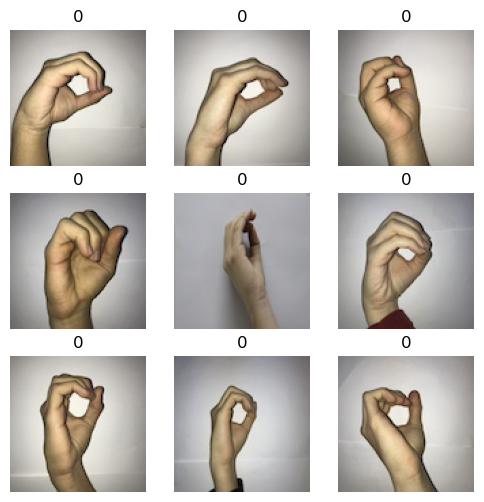

In [4]:
# plot di alcune delle immagini

figure = plt.figure(figsize=(6, 6))
cols, rows = 3,3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(105, size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1,2,0)) #nota: imshow si aspetta immagin con shape (h,w,channel) mentre i tensori torch hanno shape (channel, h, w)
plt.show()

In [5]:
# Convolutional Neural Network (VGG-like architecture)

# Implementare un modello convoluzionale composto da 3 blocchi convoluzionali costituiti
# ciascuno da:

# 1 layer conv2D (nn.Conv2d) con kernel_size=(3,3)
# 1 layer di max pooling (nn.MaxPool2d) con kernel_size=(2,2)

# i layer conv2D devono essere costituiti da rispettivamente 16, 16 e 32 filtri
# quindi il primo layer convoluzionale entra con 3 canali e esce con 16
# il secondo layer convoluzionale entra con 16 canali e esce con 16
# il terzo layer convoluzionale entra con 16 canali e esce con 32

# l'output del terzo blocco convoluzionale deve essere appiattito in un vettore 1D tramite
# il layer (nn.Flatten())

# l'output flattened deve essere passato ad un MLP per la classificazione a 10 classi finali
# costituito da 3 layer densi con 64 neuroni l'uno, intervallati da layer di droput con probabilità 0.5
# e funzioni adi attivazione relu

from torch import nn
import torch.nn.functional as F

class myVGG(nn.Module):
  def __init__(self):
    super(myVGG, self).__init__()

    # definizione dei layers

    # primo blocco convoluzionale
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3)) # ... DA SCRIVERE
    self.pool1 = nn.MaxPool2d(kernel_size=(2,2)) # ... DA SCRIVERE

    # secondo blocco convoluzionale
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3)) # ... DA SCRIVERE
    self.pool2 = nn.MaxPool2d(kernel_size=(2,2)) # ... DA SCRIVERE

    # primo blocco convoluzionale
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3)) # ... DA SCRIVERE
    self.pool3 = nn.MaxPool2d(kernel_size=(2,2)) # ... DA SCRIVERE

    # flatten
    self.flatten = nn.Flatten()# ... DA SCRIVERE

    # MLP
    self.drop1 = nn.Dropout(p=0.5) # ... DA SCRIVERE
    self.fc1 = nn.Linear(in_features=3200, out_features=64)# ... DA SCRIVERE
    self.drop2 = nn.Dropout(p=0.5) # ... DA SCRIVERE
    self.fc2 = nn.Linear(in_features=64, out_features=64)# ... DA SCRIVERE
    self.fc3 = nn.Linear(in_features=64, out_features=10)# ... DA SCRIVERE

  # forward pass: x (input) -> out
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = F.relu(self.conv3(x))
    x = self.pool3(x) # ... DA SCRIVERE

    #flatten
    x = self.flatten(x)# ... DA SCRIVERE

    #mlp
    x = self.drop1(x)
    x = F.relu(self.fc1(x))
    x = self.drop2(x)
    x = F.relu(self.fc2(x))

    out = self.fc3(x)# ... DA SCRIVERE

    return out

In [6]:
# printout del modello

model = myVGG()
print(model)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(3,100,100))
else:
  summary(model, input_size=(3,100,100))

myVGG(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3200, out_features=64, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 98, 98]             448
         MaxPool2d

In [7]:
# test di un batch sul modello non addestrato per vedere che le cose funzionino

# leggere un batch da dataloaders['train']
# spostare su device modello e dati
# calcolare la predizione del modello
# printare la shape dei dati in input, in output e il valore dell'output del primo
# evento del batch

xa, xb = next(iter(dataloaders['train']))

xa = xa.to(device)
xb = xb.to(device)
model.to(device)

res = model(xa)
print(res.shape)
print(res[0,0])

# ... DA SCRIVERE

torch.Size([128, 10])
tensor(0.1048, device='cuda:0', grad_fn=<SelectBackward0>)


In [ ]:
#install torchmetrics: collection of useful PyTorch metrics implementations and an easy-to-use API to create custom metrics
%pip install torchmetrics

In [8]:
# loss function, accuracy, optimzer

# usare CrossEntropyLoss, Accuracy. Adam come ottimizzatore con lerning rate inziaile LR_ST = 1e-3

# loss function
loss_func = nn.CrossEntropyLoss()# ... DA SCRIVEREs

# metric accuracy
from torchmetrics.classification import Accuracy

metric_fun = Accuracy(task="multiclass", num_classes=10)# ... DA SCRIVERE
metric_fun = metric_fun.to(device) #NOTA: va spostata anche essa nel device in cui si esegue il cacolo e sono presenti i tensori

# ottmizzatore: usiamo Adam
from torch import optim
LR_ST = 1e-3
opt =  optim.SGD(model.parameters(), lr=LR_ST)# ... DA SCRIVERE

# aggiungiamo uno scheduler per il LR che diminusice il LR a intervalli fissati
# ogni 15 epoche riduce il learning rate di un fattore gamma: lr = lr*gamma
scheduler = optim.lr_scheduler.StepLR(opt, 15, gamma=0.1, last_epoch=-1)

In [9]:
# Checkpoints functions
# attraverso i checkpoints possiamo interagire con il modello durante il run-time
# Per esempio si puo' salvare il modello ad ogni epoca

# Checkpoint per salvare il modello durante il training (solo il best model)
# salviamo non solo il modello ma anche alcuni metadati addizionali che possono essere utili
# salviamo le informazioni in un dizionario python che associa a diverse chiavi diverse
# informazioni
class SaveBestModel:
    def __init__(self, best_valid_loss=float('inf'), file_name='best_model'): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss
        self.file_name = file_name

    def __call__(
        self, current_valid_loss,
        epoch, model, optimizer, criterion, metric, verbose=False
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss

            if verbose:
              print(f"\nBest validation loss: {self.best_valid_loss}")
              print(f"\nSaving best model for epoch: {epoch+1}\n")

            # method to save a model (the state_dict: a python dictionary object that
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html

            torch.save({'model' : model,
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'metric': metric,
                }, self.file_name + '.pt')

In [1]:
# Training function ... la stessa usata la volta scorsa ...
import time

def train_model(nn_model, criterion, metric, n_epochs, dl_train, dl_vali, verbose=False):

  save_best_model = SaveBestModel(file_name='cnn_model')

  # liste su cui salvare il valore della loss e della metrica ad ogni epoca per poterli graficare in funzione
  # dell'epoca a fine addestramento
  hist_loss = []
  hist_metric = []
  hist_vloss = []
  hist_vmetric = []


  # loop sulle epoche
  for epoch in range(n_epochs):
    t0 = time.time()

    # training step (in cui aggiorniamo i pesi della rete neurale)
    nn_model.train()
    train_loss = 0
    train_metric = 0
    counter = 0
    for xb, yb in dl_train:
        counter += 1
        xb=xb.to(device) #copio il mini batch di dati sulla CPU/GPU
        yb=yb.to(device)

        pred = nn_model(xb) #predizione del modello

        # calcolo loss e metrica
        loss = criterion(pred, yb)
        if metric != None:
          tmetric = metric(pred, yb)

        # aggiorno la loss e metrica totale
        train_loss += loss.item()
        if metric != None:
          train_metric += tmetric.item()

        # backpropagation
        opt.zero_grad() #resetta i gradienti prima di eseguire la backpropagation (importante!)
        loss.backward() #calcola i gradeinti della loss
        opt.step() #aggiorna i pesi


    train_loss /= counter
    hist_loss.append(train_loss)

    if metric != None:
      train_metric /= counter
      hist_metric.append(train_metric)


    # validation step (non vengono aggiornati i pesi)
    nn_model.eval()
    vali_loss = 0
    vali_metric = 0
    counter = 0
    with torch.no_grad(): #evita che vengano cacolati automaticamente i gradienti
      for xb, yb in dl_vali:
        counter += 1
        xb=xb.to(device)
        yb=yb.to(device)

        pred = nn_model(xb) #predizione del modello

        # calcolo loss e metrica
        vloss = criterion(pred, yb)
        vali_loss += vloss.item()

        if metric != None:
          vmetric = metric(pred, yb)
          vali_metric += vmetric.item()

    vali_loss /= counter
    hist_vloss.append(vali_loss)

    if metric != None:
      vali_metric /= counter
      hist_vmetric.append(vali_metric)


    elapsed_time = time.time()-t0
    
    if verbose:
      if metric != None:
        print("epoch: %d, time(s): %.4f, lr: %.6f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f"
              % (epoch+1, elapsed_time, scheduler.get_last_lr()[-1], train_loss, train_metric, vali_loss, vali_metric))
      else:
        print("epoch: %d, time(s): %.4f, lr: %.6f, train loss: %.6f, vali loss: %.6f"
              % (epoch+1, elapsed_time, scheduler.get_last_lr()[-1], train_loss, vali_loss))
    else: 
      print("running epoch: %d" % (epoch+1))
    # update learning rate schedule
    scheduler.step()

    save_best_model(vali_loss, epoch, nn_model, opt, criterion, metric, verbose)

  return nn_model, hist_loss, hist_metric, hist_vloss, hist_vmetric

In [11]:
# Training

model = myVGG()
model.to(device)

LR_ST = 2e-3
opt = optim.Adam(model.parameters(), lr=LR_ST)

scheduler = optim.lr_scheduler.StepLR(opt, 10, gamma=0.85, last_epoch=-1)
metric_fun = metric_fun.to(device)

# numero di epoche
epochs = 100

model, hist_loss, hist_metric, hist_vloss, hist_vmetric = train_model(nn_model=model, criterion=loss_func, 
                                                                      metric=metric_fun, n_epochs=epochs, 
                                                                      dl_train=dataloaders['train'], dl_vali=dataloaders['vali'],
                                                                      verbose=True)

epoch: 1, time(s): 6.2186, lr: 0.002000, train loss: 2.306128, train metric: 0.090278, vali loss: 2.302931, vali metric: 0.119792

Best validation loss: 2.3029313882191977

Saving best model for epoch: 1

epoch: 2, time(s): 1.5463, lr: 0.002000, train loss: 2.302882, train metric: 0.097222, vali loss: 2.298506, vali metric: 0.135417

Best validation loss: 2.298506021499634

Saving best model for epoch: 2

epoch: 3, time(s): 1.2117, lr: 0.002000, train loss: 2.291994, train metric: 0.129340, vali loss: 2.264229, vali metric: 0.239583

Best validation loss: 2.2642294565836587

Saving best model for epoch: 3

epoch: 4, time(s): 1.2220, lr: 0.002000, train loss: 2.189500, train metric: 0.197917, vali loss: 1.958727, vali metric: 0.395833

Best validation loss: 1.9587271213531494

Saving best model for epoch: 4

epoch: 5, time(s): 1.1611, lr: 0.002000, train loss: 1.871594, train metric: 0.325521, vali loss: 1.281247, vali metric: 0.601562

Best validation loss: 1.2812471389770508

Saving b

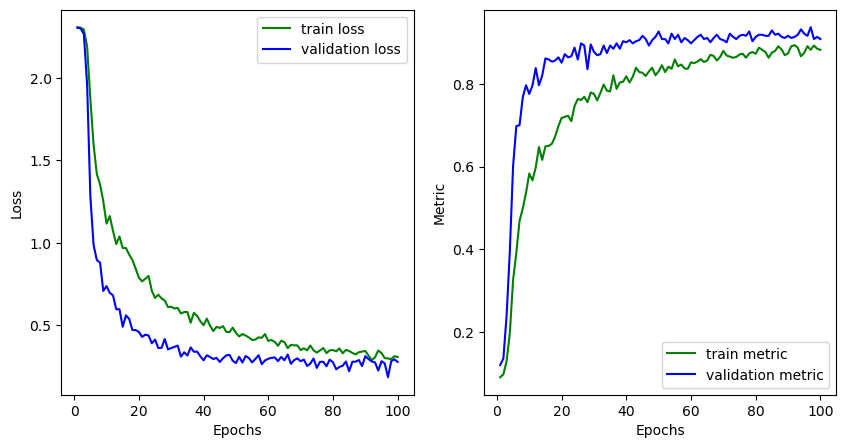

In [13]:
# grafico monitoring training
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vloss)+1), hist_vloss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1,len(hist_metric)+1),hist_metric, color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(hist_vmetric)+1),hist_vmetric, color='blue', linestyle='-', label='validation metric')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.show()

In [14]:
# test set perfromance

# lettura del modello
model_data = torch.load('./cnn_model.pt')
print('Best model at epoch: ', model_data['epoch'])
model = model_data['model']
model.eval() #va sempre fatto per settare eventuali layer di droput e batch norm in evaluation model

# Non è strettamento necessario girare sulla GPU per l'inferenza (non richiede grande potenza di calcolo)
model.to(torch.device('cpu'))
metric_fun = metric_fun.to('cpu')

loss = 0
metric = 0
counter = 0

for xb, yb in dataloaders['test']:
  counter += 1
  xb=xb.to('cpu')
  yb=yb.to('cpu')
  pred = model(xb)

  loss += loss_func(pred, yb).item()
  metric += metric_fun(pred, yb).item()


loss /= counter
metric /= counter

print('Test loss/accuracy: ',loss, ' / ', metric)

Best model at epoch:  97
Test loss/accuracy:  0.2789786358674367  /  0.9270833333333334


Confusion Matrix:


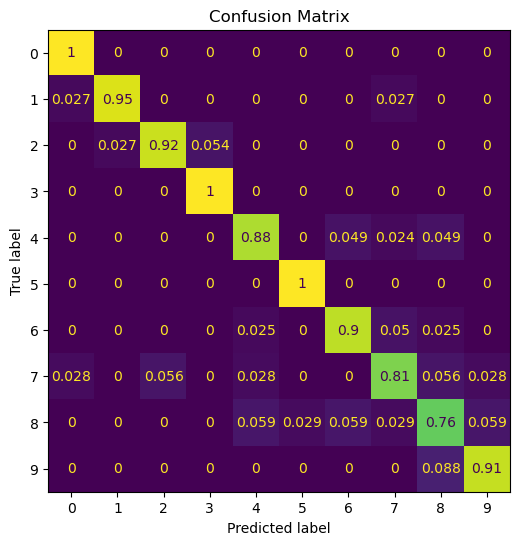

In [15]:
#confusion matrix

predictions = np.empty(shape=(0,))
truths = np.empty(shape=(0,))

for xb, yb in dataloaders['test']:
  counter += 1
  xb=xb.to('cpu')
  yb=yb.to('cpu')
  pred = model(xb)

  res = torch.argmax(pred, dim=1)

  predictions = np.concatenate((predictions,res.detach().numpy()))
  truths = np.concatenate((truths,yb.detach().numpy()))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
c_mat = confusion_matrix(predictions, truths, normalize='true')
print("Confusion Matrix:")
labels = ['0','1','2','3','4','5','6','7','8','9']

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=c_mat, display_labels=labels)
disp.plot(ax = ax)
disp.ax_.set_title('Confusion Matrix')
disp.im_.colorbar.remove()
plt.show()

### Risolviamo la task di classificazione utilizzando una rete CNN preaddestrata su un grande dataset (imagenet) e applicando una tecnica di transfer learning:


1.   si definisce e carica iun modello preaddestrato da pytorch
2.   si modifica l'MLP finale del modello adattandolo al nostro task specifico (per esempio classificazione a 10 classi)
3.   si congelano i pesi dei blocchi convoluzionali e si addestra solo l'MLP sul nostro dataset
4.   si rilasciano i pesi dei layer convoluzionali e si fa un fine tuning (training di poche eopoche con un learning rate molto piccolo)



In [16]:
try:
  model.cpu()
  del model
  print("'model' eliminato")
except: print("'model' non definito")
finally:
  import gc
  gc.collect()
  print("Garbage collected")
  torch.cuda.empty_cache()
  print("CUDA cache clear")

'model' eliminato
Garbage collected
CUDA cache clear


In [23]:
# carichiamo uno dei modelli preaddestrati da torchvision
from torchvision import datasets, transforms, models

# esempio densenet121
model = models.densenet121(weights='DEFAULT')

print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [24]:
# congelo i parametri del modello

for param in model.parameters():
    param.requires_grad = False

# aggiungo l'MLP per la classificazione

# OrderedDict è una versione più sofisiticata dei dizionari di python che permette di ricordare l'ordine
# in cui gli elementi sono stati aggiunti al dizionario
from collections import OrderedDict

classifier = nn.Sequential(OrderedDict([
    ('dropout1',nn.Dropout(0.5)),
    # define the inputs must be 1024 for densent121 model
    ('fc1',nn.Linear(1024,64)),
    ('relu1', nn.ReLU()),
    ('dropout2',nn.Dropout(0.5)),
    ('fc2',nn.Linear(64,64)),
    ('relu2', nn.ReLU()),
    ('output',nn.Linear(64,10)),
    #('output', nn.LogSoftmax(dim=1))
]))

# Un altro modo è quello di definire la una classe che eredita nn.Module
class MyClassifier(nn.Module):
  def __init__(self):
    super(MyClassifier, self).__init__()
    self.dropout1 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(1024,64)
    self.relu1 = nn.ReLU()
    self.dropout2 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(64,64)
    self.relu2 = nn.ReLU()
    self.output = nn.Linear(64,10)
    
  def forward(self, x):
    x = self.dropout1(x)
    x = self.fc1(x)
    x = self.relu1(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    x = self.relu2(x)
    out = self.output(x)
    return out


model.classifier = MyClassifier() # oppure = classifier

In [25]:
# loss e ottmizzatore

loss_func = nn.CrossEntropyLoss() #cross entropy loss
# loss_func = nn.NLLLoss()

# metric accuracy
from torchmetrics.classification import Accuracy

metric_fun = Accuracy(task="multiclass", num_classes=10)
metric_fun = metric_fun.to(device) #NOTA: va spostata anche essa nel device in cui si esegue il cacolo e sono presenti i tensori

# ottmizzatore: usiamo Adam
from torch import optim
LR_ST = 1e-3
opt = optim.Adam(model.parameters(), lr=LR_ST)

In [117]:
# dati: densenet121 richiede immagini in input didimensione 224x224 (è stato addestrato con immagini
# di imagnet di quella dimensione, dobbiamo fare un resize delle immagini del nostro campione)

# lettura dei dati usando torchvision

data_dir = 'Dataset'
test_dir = 'Dataset_test'

# definizione di un torchvision transform costituito da una composizione di trasformazioni utili
# di processamento dei dati e data augmentation

train_transforms = transforms.Compose([#transforms.RandomRotation(10), #applica una rotazione random +/- 10 deg
                                       #transforms.RandomHorizontalFlip(), #applica un flip random dei pixel orizontal
                                       transforms.Resize((224,224)), #assicura che l'immagine sia 224,224
                                       transforms.ToTensor(), #converte in tensori torch
                                      ])

# la data augmentation è applicata solo alle immagini di training
test_transforms = test_transforms = transforms.Compose([
                                       transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                      ])


# trochvision.datasets mette a disposizione la funzione ImageFolder che permete di creare un dataset a partire da imagini
# salvate in folder sul filesystem, automaticamente associa label alle immagini se queste sono salvate in
# subfolders
# https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder

train_data = datasets.ImageFolder(data_dir, transform=train_transforms)
testing_data = datasets.ImageFolder(test_dir, transform=test_transforms)

print(train_data)
print(testing_data)


Dataset ImageFolder
    Number of datapoints: 1157
    Root location: Dataset
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 905
    Root location: Dataset_test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [118]:
# split test set in vali e test
test_data, vali_data = torch.utils.data.random_split(testing_data, [450, 455])

print('Trainign set size: ', len(train_data))
print('Validation set size: ',len(vali_data))
print('Test set size: ',len(test_data))

# dataloaders

batch_size = 64
subprocess = 0
dataloaders = dict() #usiamo un dizionario epr comodità
dataloaders['train'] = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=subprocess)
dataloaders['vali'] = torch.utils.data.DataLoader(vali_data, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=subprocess)
dataloaders['test'] = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True, pin_memory=True, num_workers=subprocess)

Trainign set size:  1157
Validation set size:  455
Test set size:  450


In [119]:
# Training

model.to(device)

# numero di epoche
epochs = 20

model, hist_loss, hist_metric, hist_vloss, hist_vmetric = train_model(nn_model=model, 
                                                                      criterion=loss_func, 
                                                                      metric=metric_fun, 
                                                                      n_epochs=epochs, verbose=True,
                                                                      dl_train=dataloaders['train'], dl_vali=dataloaders['vali'])

epoch: 1, time(s): 5.4733, lr: 0.000126, train loss: 2.300974, train metric: 0.141447, vali loss: 2.263647, vali metric: 0.107422

Best validation loss: 2.263647496700287

Saving best model for epoch: 1

epoch: 2, time(s): 5.0420, lr: 0.000126, train loss: 2.219277, train metric: 0.211678, vali loss: 2.166312, vali metric: 0.213449

Best validation loss: 2.166311591863632

Saving best model for epoch: 2

epoch: 3, time(s): 4.9952, lr: 0.000126, train loss: 2.138418, train metric: 0.233388, vali loss: 1.986386, vali metric: 0.459821

Best validation loss: 1.9863855093717575

Saving best model for epoch: 3

epoch: 4, time(s): 4.9851, lr: 0.000126, train loss: 1.992674, train metric: 0.310691, vali loss: 1.774878, vali metric: 0.539900

Best validation loss: 1.7748777866363525

Saving best model for epoch: 4

epoch: 5, time(s): 4.9675, lr: 0.000126, train loss: 1.806149, train metric: 0.387829, vali loss: 1.564056, vali metric: 0.614118

Best validation loss: 1.564055860042572

Saving bes

In [120]:
torch.save(model, './densenet121_model.pt')

In [121]:
# fine tuning: unfrize tutti i pesi, setto lr ad un numero molto piccolo (1e-4 o 1e-5) e riaddestro per poche epoche ...

# NOTA: si continua addestrando il modello precedentemente addestrato, non si crea un nuovo modello
model = torch.load('./densenet121_model.pt')
model.to(device)

for param in model.parameters():
    param.requires_grad = True

LR_ST = 1e-5
opt = optim.Adam(model.parameters(), lr=LR_ST)


# numero di epoche
epochs = 10

model, hist_loss, hist_metric, hist_vloss, hist_vmetric = train_model(nn_model=model, criterion=loss_func, metric=metric_fun, n_epochs=epochs, dl_train=dataloaders['train'], dl_vali=dataloaders['vali'])

C:\Users\Mark\anaconda3\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


running epoch: 1
running epoch: 2
running epoch: 3
running epoch: 4
running epoch: 5
running epoch: 6
running epoch: 7
running epoch: 8
running epoch: 9
running epoch: 10


Confusion Matrix:


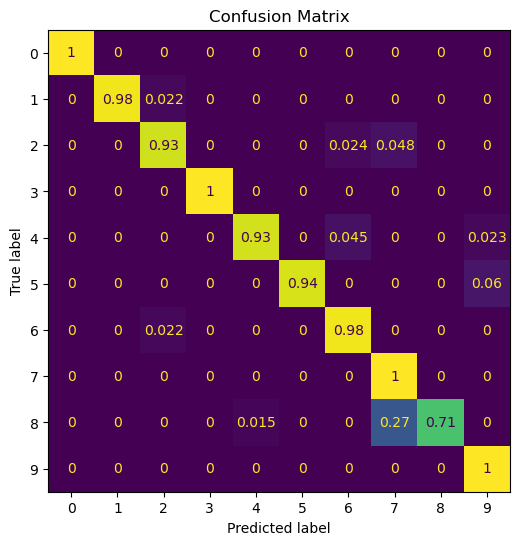

In [122]:
#confusion matrix

predictions = np.empty(shape=(0,))
truths = np.empty(shape=(0,))

for xb, yb in dataloaders['test']:
  counter += 1
  xb=xb.to('cpu')
  yb=yb.to('cpu')
  model.to('cpu')
  pred = model(xb).to('cpu')

  res = torch.argmax(pred, dim=1)

  predictions = np.concatenate((predictions,res.detach().numpy()))
  truths = np.concatenate((truths,yb.detach().numpy()))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
c_mat = confusion_matrix(predictions, truths, normalize='true')
print("Confusion Matrix:")
labels = ['0','1','2','3','4','5','6','7','8','9']

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=c_mat, display_labels=labels)
disp.plot(ax = ax)
disp.ax_.set_title('Confusion Matrix')
disp.im_.colorbar.remove()
plt.show()

**Compiti addizionali per casa:**

* giocoare con il modello CNN cambiano parametri e/o architettura, eliminare  dropout e/o cambiare probabilità di dropout

* provare a fare transferlearning usando un'atra CNN SOTA preaddestrata, per esempio vgg19, e/o resnet152